# Load and transform data
Here we load the data from CSV files, investigate the distributions and convert the data to the form used for the models and save it in better file formats than CSV.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer as skQT

#### Define file paths

##### The datasets used for the project

In [2]:
# # Full ARCHS4 gene expression data
# archs4_full_path = os.getcwd() + "/Data/iso_02456/archs4_gene_expression.tsv"

# # subset of the ARCHS4 gene expression data
# archs4_subset = os.getcwd() + "/Data/iso_02456/archs4_gene_expression_subset.tsv"

# # GTEX gene expression data
# gtex_gene_expression = os.getcwd() + "/Data/iso_02456/gtex_gene_expression.tsv"

# # GTEX isoform expression data
# gtex_isoform_expression = os.getcwd() + "/Data/iso_02456/gtex_isoform_expression.tsv"
# gtex_isoform_expression_transposed = os.getcwd() + "/Data/iso_02456/gtex_isoform_expression_transposed.tsv"

# # Filter list for subset of isoforms
# gtex_isoform_filter = os.getcwd() + "/isoforms_filter.txt"

##### Subsets of data

In [3]:
# Full ARCHS4 gene expression data
archs4_full_path = os.getcwd() + "/Data/iso_02456/archs4_gene_expression_subset.tsv"

# subset of the ARCHS4 gene expression data
archs4_subset = os.getcwd() + "/Data/iso_02456/archs4_gene_expression_subset.tsv"

# GTEX gene expression data
gtex_gene_expression = os.getcwd() + "/Data/iso_02456/gtex_gene_expression_subset_transposed.tsv"

# GTEX isoform expression data
gtex_isoform_expression = os.getcwd() + "/Data/iso_02456/gtex_isoform_expression_subset.tsv"
gtex_isoform_expression_transposed = os.getcwd() + "/Data/iso_02456/gtex_isoform_expression_subset_transposed.tsv"

# Filter list for subset of isoforms
gtex_isoform_filter = os.getcwd() + "/isoforms_filter.txt"

## ARCHS4 data
This is our training data for making the variational auto-encoder

### Investigating data distribution

In [4]:
# Load subset of ARCHS4 data from tsv
print("Loading ARCHS4 data subset...")
start_ = time.time()
data = np.loadtxt(archs4_subset, dtype=np.float32, delimiter='\t', skiprows=1)
end_ = time.time()
print(f"Loading ARCHS4 data subset took {end_-start_} seconds.")

# transpose data so that we have genes as columns (variables) 
# and samples as rows (observations)
data = data.T
data_plot = data.flatten()

Loading ARCHS4 data subset...
Loading ARCHS4 data subset took 0.019479751586914062 seconds.


#### Plotting raw data
We removed values above a threshold to make the plot clearer

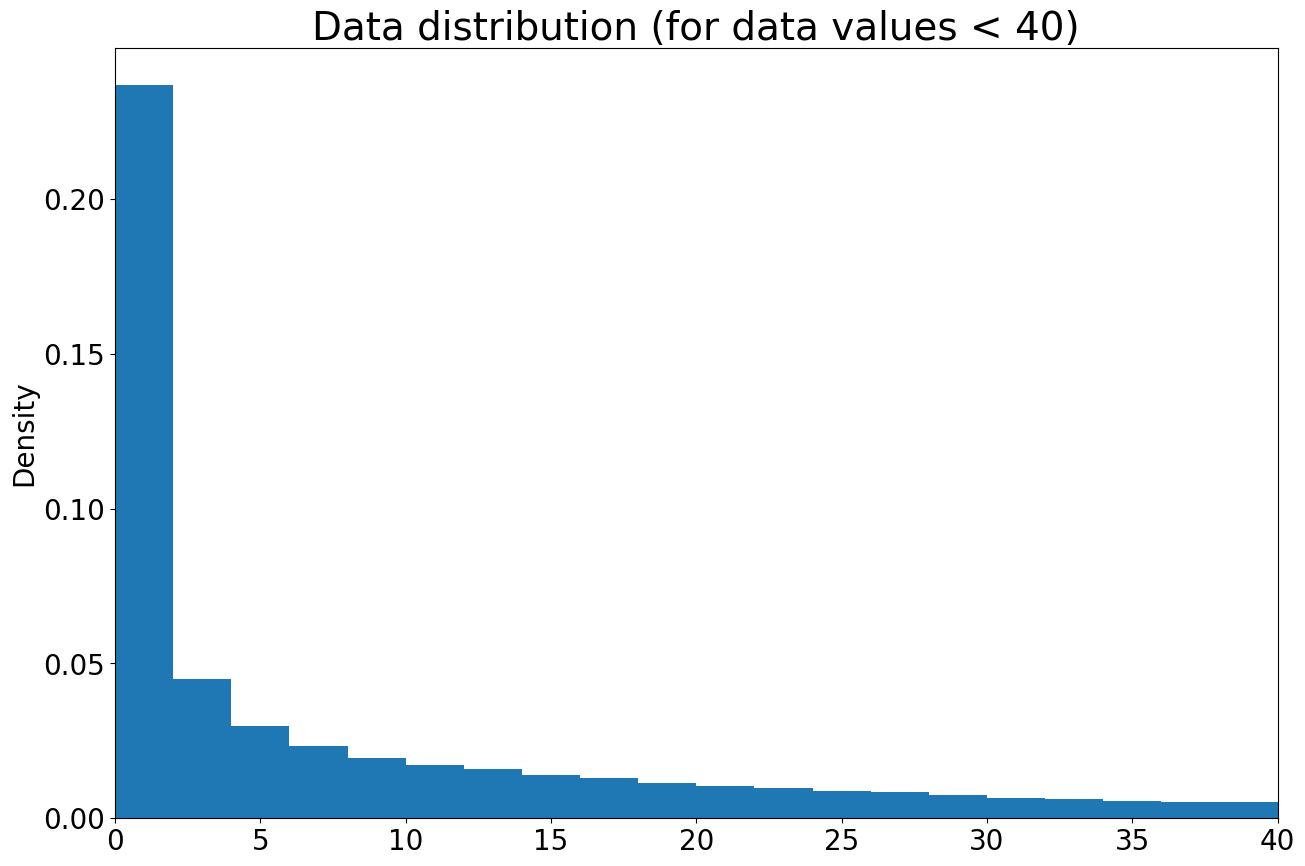

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(data_plot, bins=20, range=(0.00000001,40), density=True)
ax.set_title("Data distribution (for data values < 40)", fontsize = 28)
ax.set_ylabel("Density", fontsize = 20)
ax.set_xlim(0, 40)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig(os.getcwd()+"/Figures/Raw_data_distribution.png")
plt.show()

#### Plotting log2-transformed data

In [6]:
# Log2-transform with pseudocount of 1
data_plot = np.log2(data_plot+1)

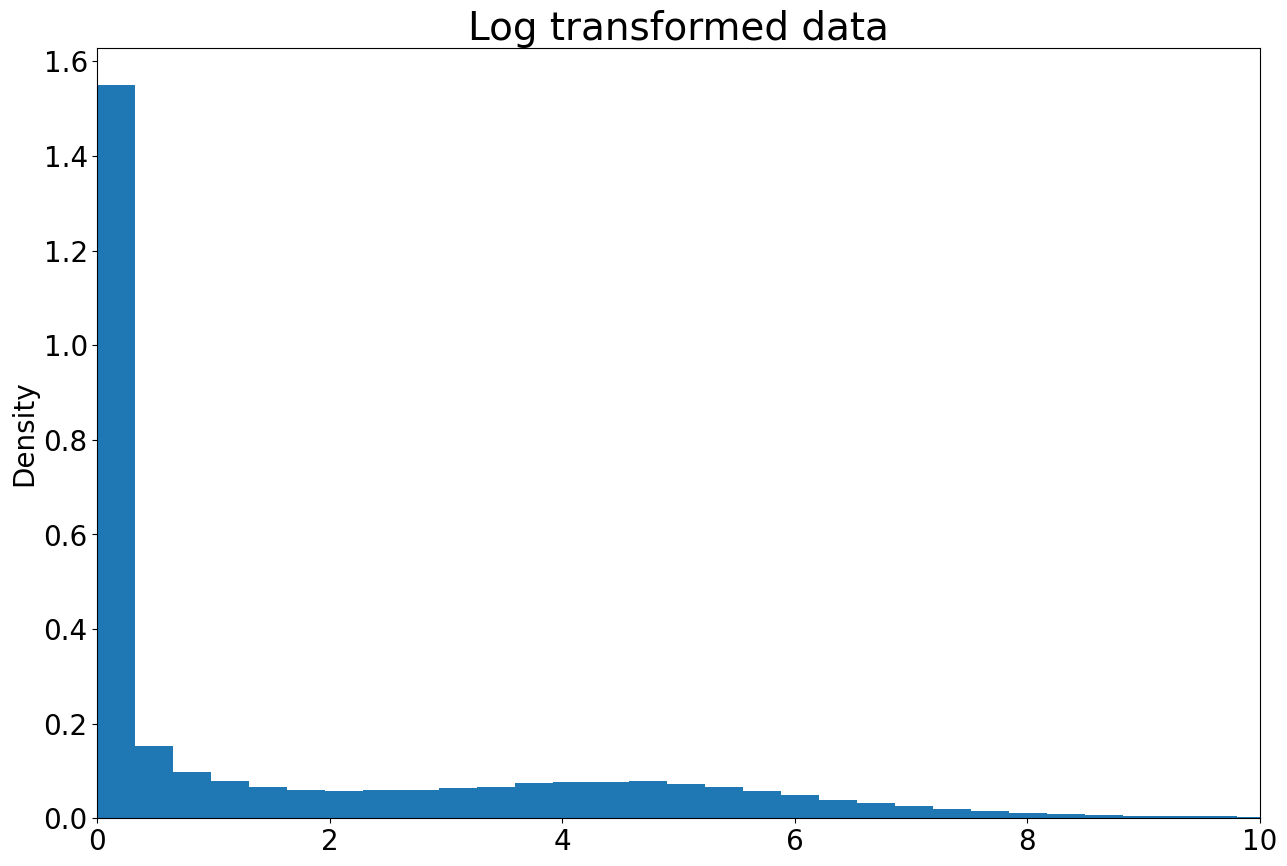

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(data_plot, bins=50, density=True)
ax.set_title("Log transformed data", fontsize = 28)
ax.set_ylabel("Density", fontsize = 20)
ax.set_xlim(0, 10)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig(os.getcwd()+"/Figures/Log_transformed_data.png")
plt.show()

#### Plotting quantile transformed data

In [8]:
# Using quantile transformer from scikit-learn
quantile_transformer = skQT(output_distribution = "normal")

In [9]:
# Quantile transform all non-zero values
data_plot = data_plot[data_plot > 0].reshape(-1, 1)
data_plot = quantile_transformer.fit_transform(data_plot)

# Get the zeros from the oroginal data and append them back into the flattened array
missing_zeros = np.zeros(int(data[data == 0].shape[0] / np.prod(data.shape) * np.prod(data.shape))).reshape(-1, 1)
final_data_dist = np.concatenate((data_plot+data_plot.max(), missing_zeros),axis=0)

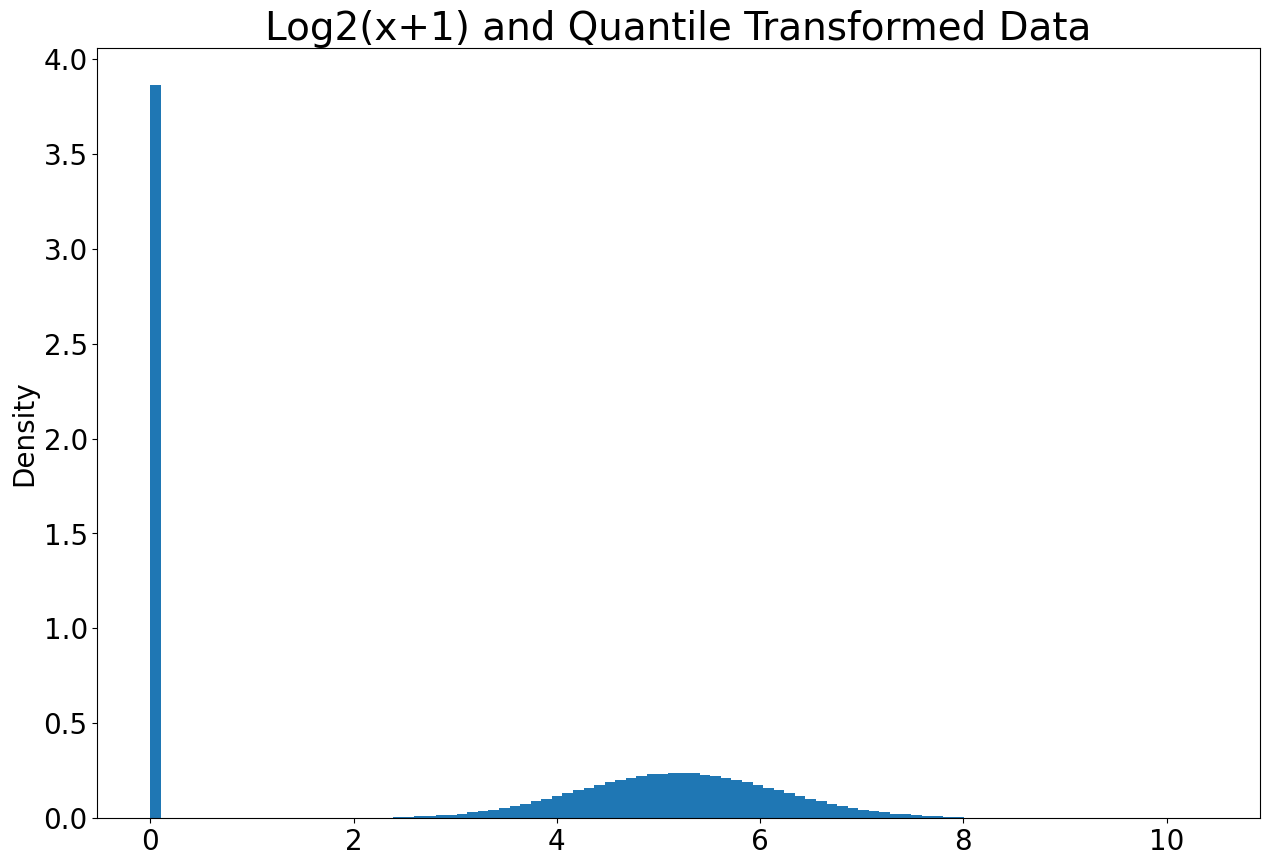

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(final_data_dist, bins=100, density=True)
ax.set_title("Log2(x+1) and Quantile Transformed Data", fontsize = 28)
ax.set_ylabel("Density", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig(os.getcwd()+"/Figures/Transformed_data_distribution.png")
plt.show()

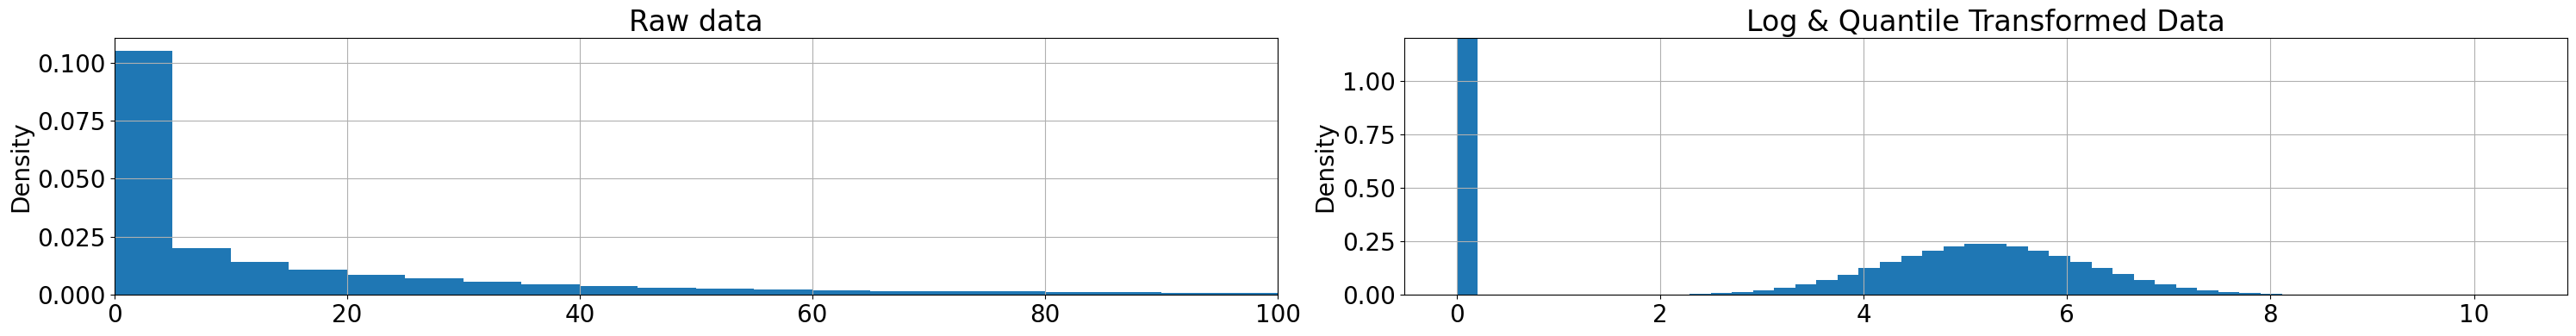

In [11]:
# Complete plot for poster
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,4))
ax1.hist(data.flatten(), bins=20, range=(0.00000001,100), density=True)
ax1.set_title("Raw data", fontsize = 24)
ax1.set_ylabel("Density", fontsize = 20)
ax1.grid()
ax1.set_xlim(0, 100)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.hist(final_data_dist, bins=50, density=True)
ax2.set_title("Log & Quantile Transformed Data", fontsize = 24)
ax2.set_ylabel("Density", fontsize = 20)
ax2.grid()
ax2.set_ylim((-0, 1.2))
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
# plt.savefig(os.getcwd()+"/Figures/Final_data_distribution_figure.png")
plt.show()

In [12]:
# Free up memory
del data, data_plot, missing_zeros, final_data_dist

### Transforming the full ARCHS4 dataset

In [13]:
# Expected size in memory (GB)
print(f"Gigabytes for full dataset (float32): {34558 * 168668 * 4 / 2**30}")

Gigabytes for full dataset (float32): 21.714079171419144


In [14]:
# Loading the full dataset using numpy
data = np.loadtxt(archs4_full_path, dtype=np.float32, delimiter='\t', skiprows=1)
data.shape

(1000, 100)

In [15]:
# Actual size in memory (GB)
print(f"Size in GB: {data.nbytes / 2**30}")

Size in GB: 0.0003725290298461914


In [16]:
# Log2-transform with pseudocount of one, then transpose so that we have
# genes as columns (variables) and samples as rows (observations)
data = np.log2(data+1).T

# Quantile transform the data to get normally distributed data
data = quantile_transformer.fit_transform(data)

# Shift data upwards so that zero values are still zero
data_max = data.max()
data = data + data_max

# Save the data as .npy format for much more efficient loading
np.save(os.getcwd() + "/Data/archs4_data_transformed.npy", data)

/home/kongcav/miniconda3/envs/DL_Project/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (100). n_quantiles is set to n_samples.
  warnings.warn(


#### Ensure that new file has the correct shape and distribution of data

In [17]:
data = np.load(os.getcwd() + "/Data/archs4_data_transformed.npy")
np.isnan(np.sum(data))

False

In [18]:
data.shape

(100, 1000)

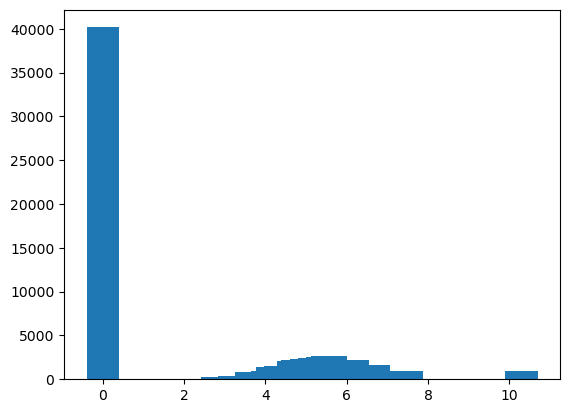

In [19]:
hist,bin_edges = np.histogram(data, bins=100)
fig,ax = plt.subplots()
ax = plt.bar(np.arange(data.min(), data.max(), (data.max()-data.min())/100), hist)
plt.show()

In [20]:
# Free up memory
del data

## GTEX Gene Expression data
This data contains the independent variables for our regression model, but they have to be encoded into a lower dimensionality through the trained VAE.

### Investigating data distribution

In [21]:
# Load GTEX gene expression dataset
print("Loading GTEX gene expression data...")
start_ = time.time()
#data = np.loadtxt(gtex_gene_expression, dtype=np.float32, delimiter='\t', skiprows=1, usecols=())
data = np.genfromtxt(gtex_gene_expression, delimiter='\t', skip_header=1, dtype=np.float32)
data = data[:,1:]
end_ = time.time()
print(f"Loading GTEX gene expression data took {end_-start_} seconds.")

Loading GTEX gene expression data...
Loading GTEX gene expression data took 0.34159302711486816 seconds.


In [22]:
# Flatten and log2-transform data
data_plot = data.flatten()
data_plot = np.log2(data_plot+1).T

# Quantile transform all non-zero values
data_plot = data_plot[data_plot > 0].reshape(-1, 1)
data_plot = quantile_transformer.fit_transform(data_plot)

# Get the zeros from the oroginal data and append them back into the flattened array
missing_zeros = np.zeros(int(data[data == 0].shape[0] / np.prod(data.shape) * np.prod(data.shape))).reshape(-1, 1)
final_data_dist = np.concatenate((data_plot+data_plot.max(), missing_zeros),axis=0)

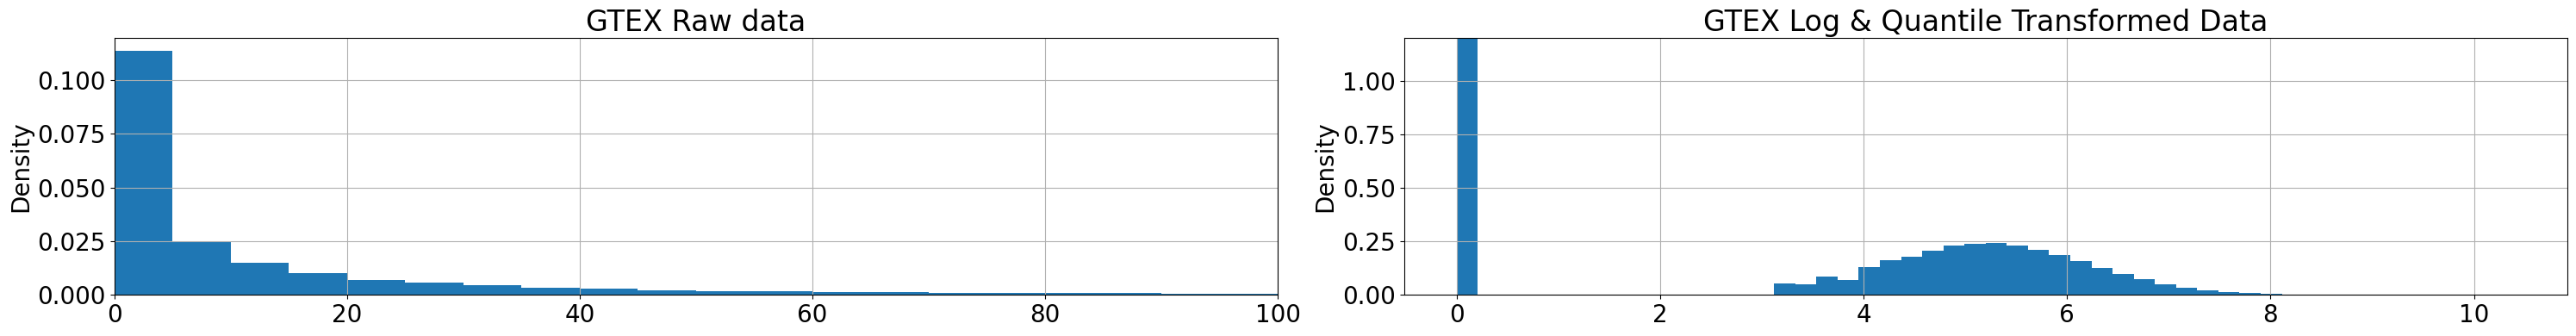

In [23]:
# Plot initial and final data distributions
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(30,4))
ax1.hist(data.flatten(), bins=20, range=(0.00000001,100), density=True)
ax1.set_title("GTEX Raw data", fontsize = 24)
ax1.set_ylabel("Density", fontsize = 20)
ax1.grid()
ax1.set_xlim(0, 100)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.hist(final_data_dist, bins=50, density=True)
ax2.set_title("GTEX Log & Quantile Transformed Data", fontsize = 24)
ax2.set_ylabel("Density", fontsize = 20)
ax2.grid()
ax2.set_ylim((-0, 1.2))
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
# plt.savefig(os.getcwd()+"/Figures/gtex_gene_distribution_figure.png")
plt.show()

In [24]:
# Free up memory
del data_plot, missing_zeros, final_data_dist

### Transforming the GTEX gene expression dataset
This is done in the same way as the ARCHS4 dataset.

In [25]:
# Log2-transform with pseudocount of one, then transpose so that we have
# genes as columns (variables) and samples as rows (observations)
data = np.log2(data+1).T

# Quantile transform the data to get normally distributed data
data = quantile_transformer.fit_transform(data)

# Shift data upwards so that zero values are still zero
data_max = data.max()
data = data + data_max

# Save the data as .npy format for much more efficient loading
np.save(os.getcwd() + "/Data/gtex_gene_expression.npy", data)

In [26]:
# Free up memory
del data

## GTEX Isoform data
These are our dependent (target) variables for the regression model.
Here we needed to preserve the sample and isoform names in order to be able to A) subset the isoforms and B) map the samples to their corresponding tissues.

In [27]:
# Indexers for samples
with open(gtex_isoform_expression) as f:
    samples = f.readline().split('\t')

# Removing sneaky newline chars
samples = [i.replace('\n','') for i in samples]

# Headers for isoforms
with open(gtex_isoform_expression_transposed) as f:
    isoforms = f.readline().split('\t')

# Removing sneaky newline chars
isoforms = [i.replace('\n','') for i in isoforms]
    
# Removing the "sample_id" header
isoforms.pop(0)
samples.pop(0)

''

In [28]:
# Loading the GTEX isoform expression data itself
with open(gtex_isoform_expression_transposed) as f:
    ncols = len(f.readline().split('\t'))

print("Loading data...")
start_ = time.time()
iso_data = np.loadtxt(gtex_isoform_expression_transposed, dtype=np.float32, delimiter='\t', skiprows=1, usecols=range(1,ncols))
end_ = time.time()
print(f"Loaded isoform data from .tsv in {end_-start_} seconds")

Loading data...
Loaded isoform data from .tsv in 0.0636899471282959 seconds


### Check data distribution

In [29]:
iso_plot = iso_data.flatten()

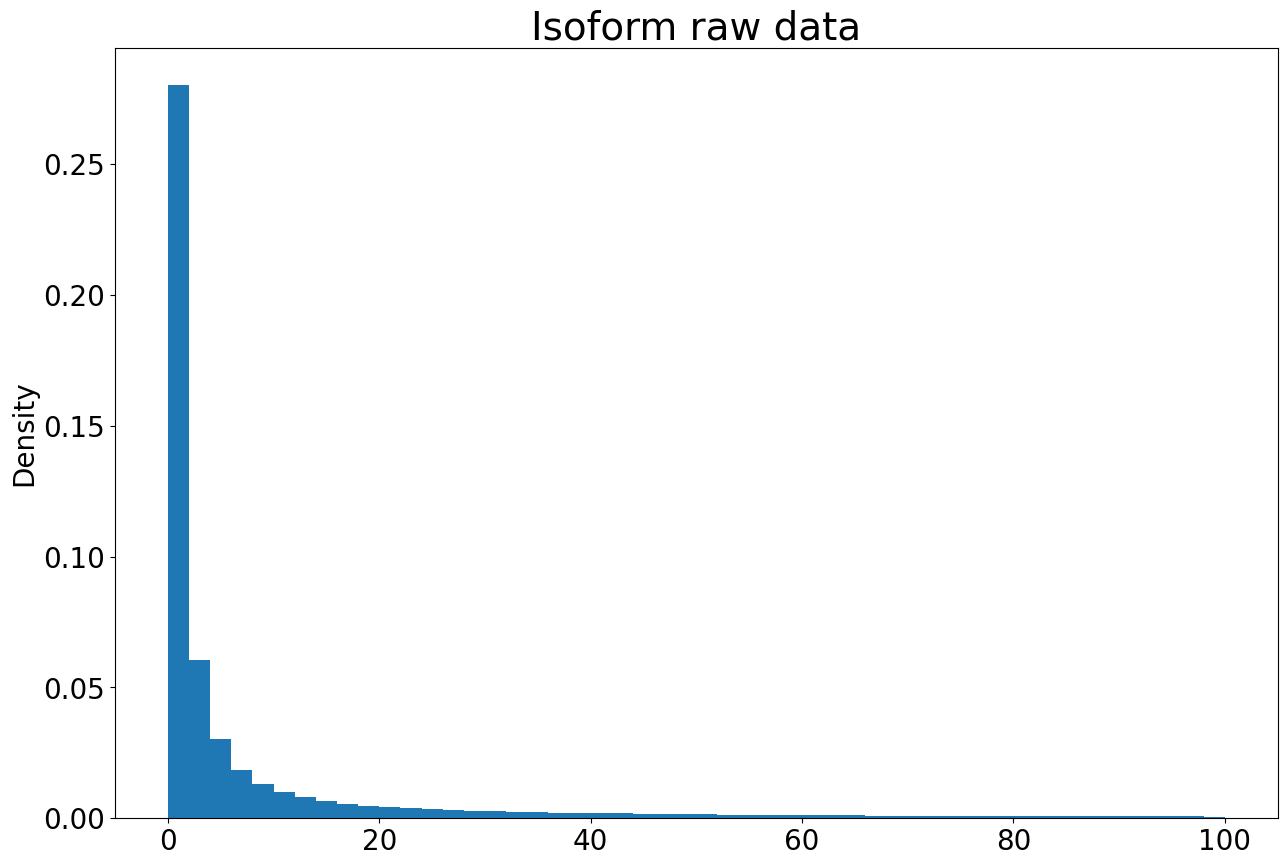

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(iso_plot, bins=50, range=(0.00000001,100), density=True)
ax.set_title("Isoform raw data", fontsize = 28)
ax.set_ylabel("Density", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig(os.getcwd()+"/Figures/iso_data.png")
plt.show()

In [31]:
# Log2-transform with a pseudocount of one
iso_data = np.log2(iso_data + 1)

In [32]:
iso_plot = iso_data.flatten()

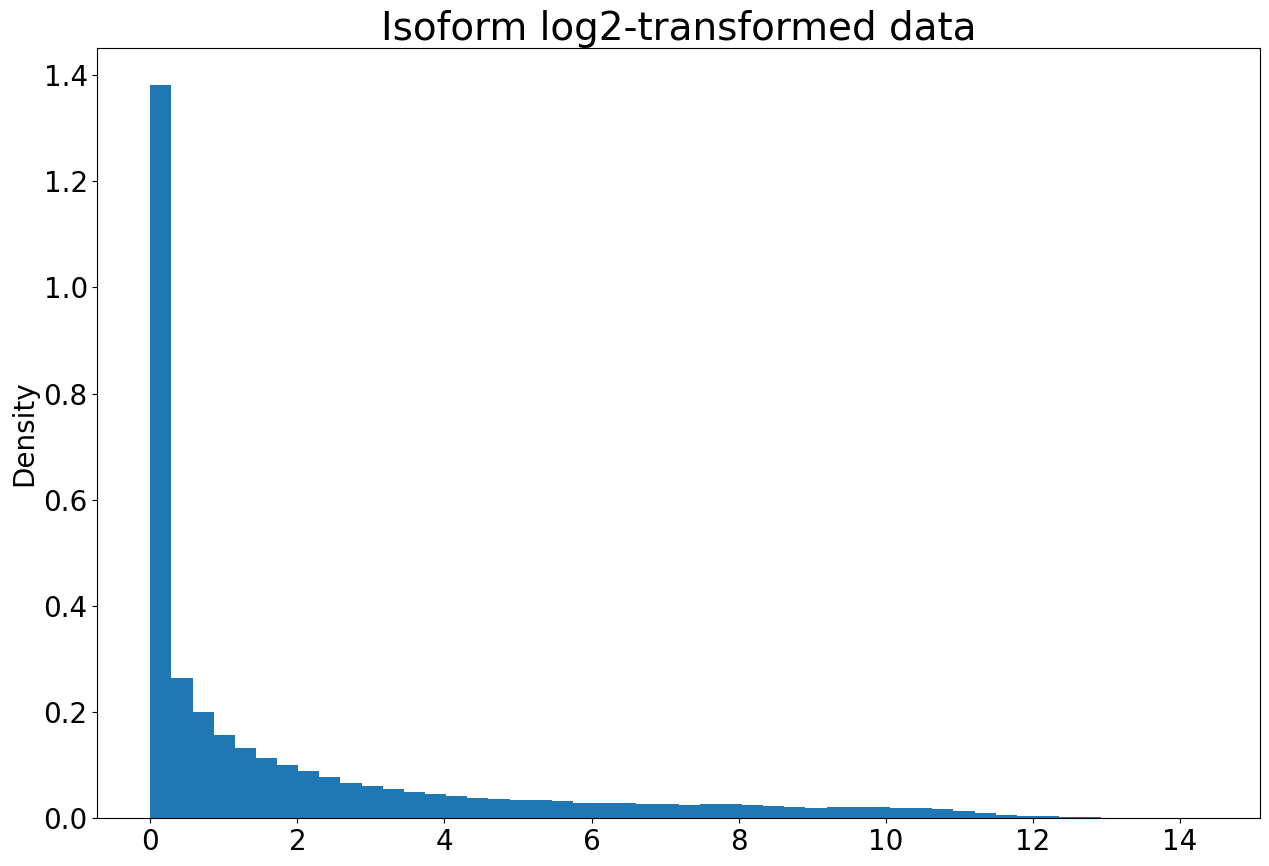

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
ax.hist(iso_plot, bins=50, density=True)
ax.set_title("Isoform log2-transformed data", fontsize = 28)
ax.set_ylabel("Density", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig(os.getcwd()+"/Figures/Log_transformed_iso_data.png")
plt.show()

### Save to disk

In [34]:
# Save data to disk as .pickle file
gtex_iso_data = pd.DataFrame(data = iso_data, index = samples, columns = isoforms)
gtex_iso_data.to_pickle(os.getcwd()+"/Data/gtex_isoform_expression.pickle")

In [35]:
# Free up memory
del iso_data, iso_plot, samples, isoforms

## GTEX Isoform data subset
Here we subset the isoform data to extract the 965 isoforms suggested for analysis by Kristoffer Vitting-Seerup.

In [36]:
# Load the list of 965 isoforms on which to focus for our regression model
isoform_filter_list = []
with open(gtex_isoform_filter) as f:
    for line in f:
        isoform_filter_list.append(line)

# Removing sneaky newline chars
isoform_filter_list = [i.replace('\n','') for i in isoform_filter_list]

In [37]:
# Filter the isoforms
gtex_iso_data_subset = gtex_iso_data[isoform_filter_list]

# Save subset of 965 isoforms to disk as .pickle file
gtex_iso_data_subset.to_pickle(os.getcwd()+"/Data/gtex_isoform_expression_965_subset.pickle")

In [43]:
gtex_iso_data_subset.to_numpy().shape

(1000, 965)